In [1]:
import pandas as pd
import zipfile
with zipfile.ZipFile('IMDB Dataset.csv.zip') as f:
    f.extractall('c00ntent')
df = pd.read_csv('c00ntent\IMDB Dataset.csv')


<>:5: SyntaxWarning: invalid escape sequence '\I'
<>:5: SyntaxWarning: invalid escape sequence '\I'
C:\Users\acer\AppData\Local\Temp\ipykernel_14080\84323277.py:5: SyntaxWarning: invalid escape sequence '\I'
  df = pd.read_csv('c00ntent\IMDB Dataset.csv')


In [2]:
df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.shape

(50000, 2)

In [4]:
df.dtypes

review       object
sentiment    object
dtype: object

In [5]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [6]:
# sentiment  column
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [7]:
# well balanced class

In [8]:
from bs4 import BeautifulSoup
def remove_html(text):
    return BeautifulSoup(text, "html.parser").get_text()


In [9]:
df['review'] = df['review'].apply(remove_html)

C:\Users\acer\AppData\Local\Temp\ipykernel_14080\656468003.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()


In [10]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [11]:
import contractions
def expand_contractions(text):
    return contractions.fix(text)
df['review'] = df['review'].apply(expand_contractions)

In [12]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word.lower() not in stop_words])
df['review'] = df['review'].apply(remove_stopwords)

In [13]:
df['review'] = df['review'].str.lower()

In [14]:
import spacy
from tqdm import tqdm
import pandas as pd

# Load spaCy with minimal components
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

def lemmatize_batch(texts, batch_size=200):  # Reduced for safety
    return [" ".join([token.lemma_ for token in doc]) 
            for doc in nlp.pipe(texts, batch_size=batch_size)]

# Process in smaller chunks
def process_in_chunks(df, chunk_size=1000):  # Test with 1k first
    chunks = []
    for i in tqdm(range(0, len(df), chunk_size)):
        chunk = df.iloc[i:i+chunk_size].copy()
        chunk['review'] = lemmatize_batch(chunk['review'].tolist())
        chunks.append(chunk)
    return pd.concat(chunks)

df = process_in_chunks(df)

100%|██████████| 50/50 [17:21<00:00, 20.83s/it]


In [15]:
df['review']= df['review'].str.lower()

In [16]:
import string

def remove_punctuation(text):
    
    return text.translate(str.maketrans('', '', string.punctuation))


df['review'] = df['review'].apply(remove_punctuation)

In [17]:
df.head()

,review,sentiment
0,one reviewer mention watch 1 oz episode hooked...,positive
1,wonderful little production filming technique...,positive
2,think wonderful way spend time hot summer week...,positive
3,basically family little boy jake think zombi...,negative
4,petter mattei s love time money visually stu...,positive


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000) 
X = tfidf.fit_transform(df['review'])

In [19]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [20]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X, df['sentiment'], test_size=0.2, random_state=42
)

In [21]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [22]:
from sklearn.metrics import classification_report

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [23]:
import joblib

# Save the trained model and vectorizer
joblib.dump(model, 'sentiment_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

print("Model and vectorizer saved successfully!")

Model and vectorizer saved successfully!


In [24]:
def predict_sentiment(text):
    """
    Predict sentiment for a single review text
    """
    # Preprocess the text (same pipeline as training)
    text = remove_html(text)
    text = expand_contractions(text)
    text = remove_stopwords(text)
    text = lemmatize_text(text)  # You'll need to define this wrapper
    text = text.lower()
    text = remove_punctuation(text)
    
    # Vectorize
    text_vector = tfidf.transform([text])
    
    # Predict
    prediction = model.predict(text_vector)
    probability = model.predict_proba(text_vector)
    
    return {
        'sentiment': 'positive' if prediction[0] == 1 else 'negative',
        'positive_prob': float(probability[0][1]),
        'negative_prob': float(probability[0][0])
    }

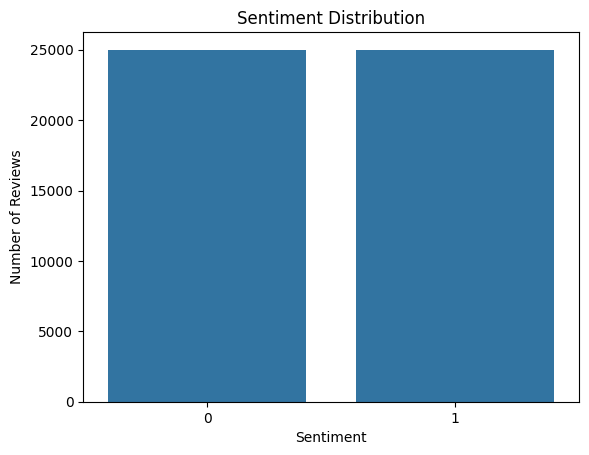

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()


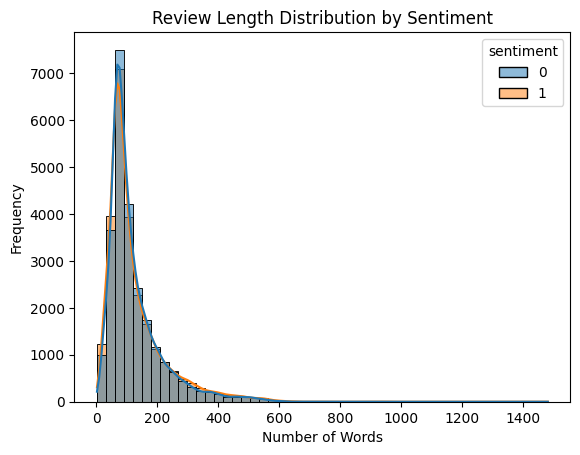

In [26]:
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
sns.histplot(data=df, x='review_length', hue='sentiment', bins=50, kde=True)
plt.title('Review Length Distribution by Sentiment')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


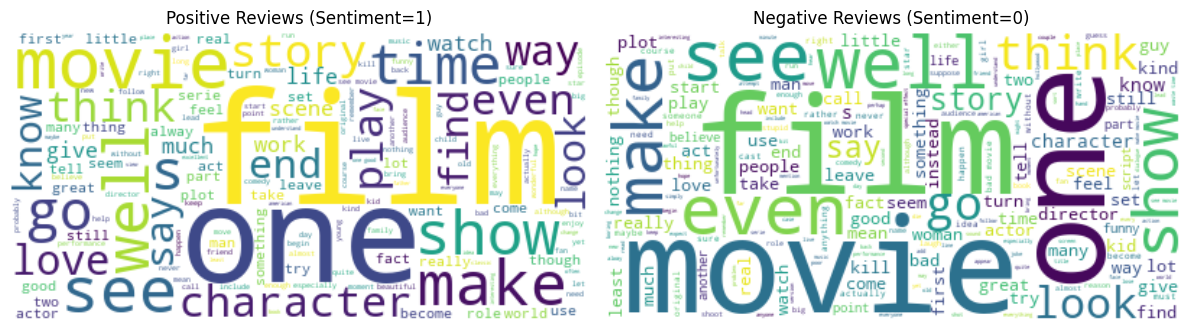

In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Clean data (drop NaN/empty reviews)
df = df.dropna(subset=['review'])
df = df[df['review'].str.strip().ne('')]

# Generate texts using numerical sentiments
pos_text = " ".join(df[df['sentiment'] == 1]['review'])  # 1 = positive
neg_text = " ".join(df[df['sentiment'] == 0]['review'])  # 0 = negative

# Plot Word Clouds
plt.figure(figsize=(12, 5))

# Positive Word Cloud
plt.subplot(1, 2, 1)
if len(pos_text) > 0:
    wc_pos = WordCloud(width=400, height=200, background_color='white').generate(pos_text)
    plt.imshow(wc_pos, interpolation='bilinear')
    plt.title('Positive Reviews (Sentiment=1)')
else:
    plt.text(0.5, 0.5, 'No positive reviews', ha='center')
plt.axis('off')

# Negative Word Cloud
plt.subplot(1, 2, 2)
if len(neg_text) > 0:
    wc_neg = WordCloud(width=400, height=200, background_color='white').generate(neg_text)
    plt.imshow(wc_neg, interpolation='bilinear')
    plt.title('Negative Reviews (Sentiment=0)')
else:
    plt.text(0.5, 0.5, 'No negative reviews', ha='center')
plt.axis('off')

plt.tight_layout()
plt.show()

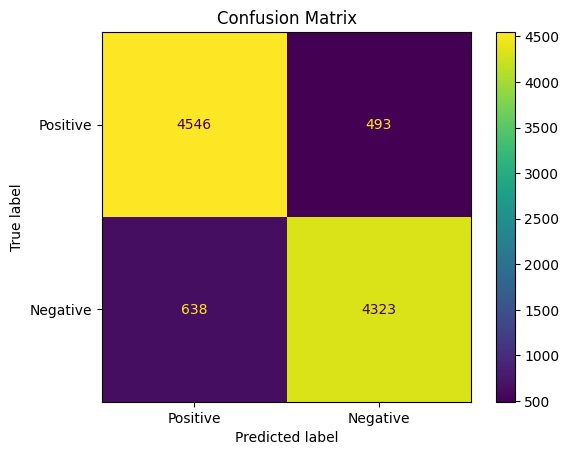

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# y_test, y_pred = ... (your test labels and predictions)
cm = confusion_matrix(y_test, predictions, labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positive', 'Negative'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()


C:\Users\acer\AppData\Local\Temp\ipykernel_14080\1775365155.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


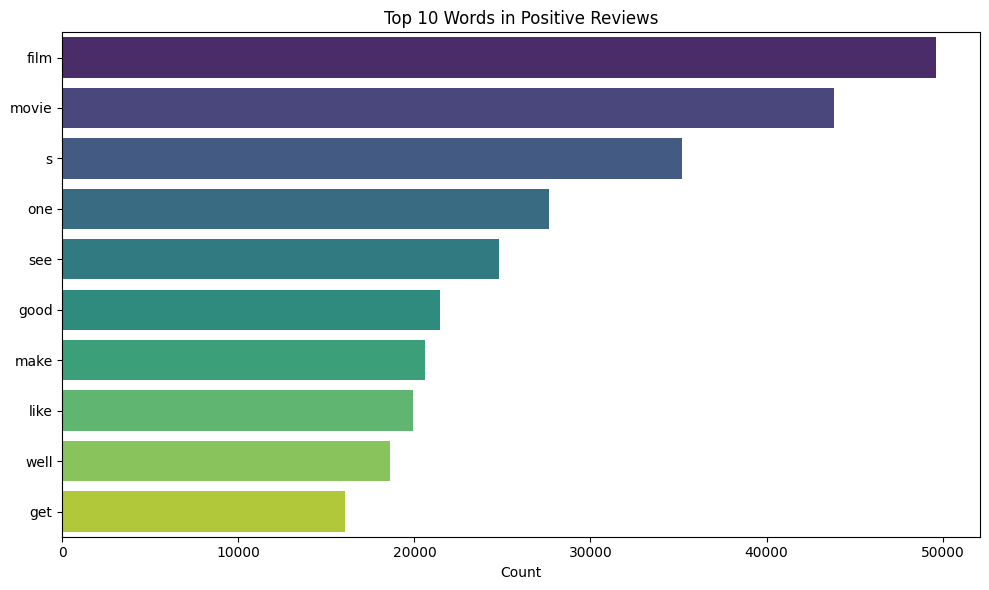

C:\Users\acer\AppData\Local\Temp\ipykernel_14080\1775365155.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


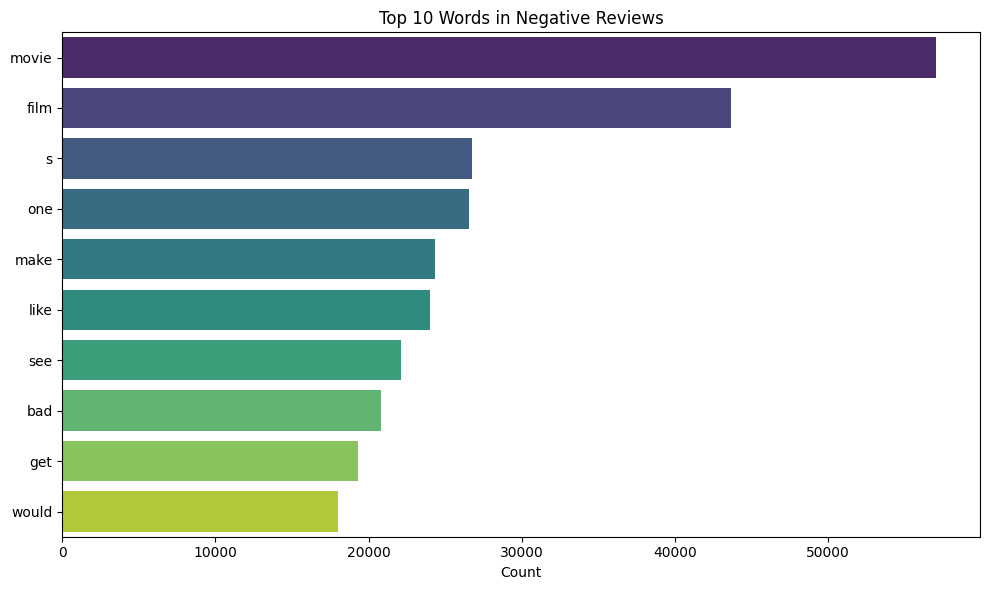

In [41]:
def plot_top_words(sentiment, n=10):
    # Clear any existing plots first
    plt.close('all')
    
    # Map string inputs to numerical values
    sentiment_map = {'positive': 1, 'negative': 0}
    if isinstance(sentiment, str):
        sentiment = sentiment_map.get(sentiment.lower(), sentiment)
    
    words = " ".join(df[df['sentiment']==sentiment]['review']).split()
    if not words:
        print(f"No words found for sentiment: {sentiment}")
        return
    
    common_words = Counter(words).most_common(n)
    if not common_words:
        print(f"No common words for sentiment: {sentiment}")
        return
        
    words, counts = zip(*common_words)
    
    # Create a new figure explicitly
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words), palette="viridis")
    plt.title(f'Top {n} Words in {"Positive" if sentiment == 1 else "Negative"} Reviews')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.show()

# Call once for each sentiment (no duplicates)
plot_top_words('positive')  # Only one positive plot
plot_top_words('negative')  # Only one negative plot